In [1]:
from timbr import Snapshot
%reload_ext timbr.notebook
%timbr SnapshotSelector

<IPython.core.display.Javascript object>

In [3]:
data = Snapshot("/Users/seangorman/.timbr/data/nba_playoffs_22k_geo_enabled.h5")

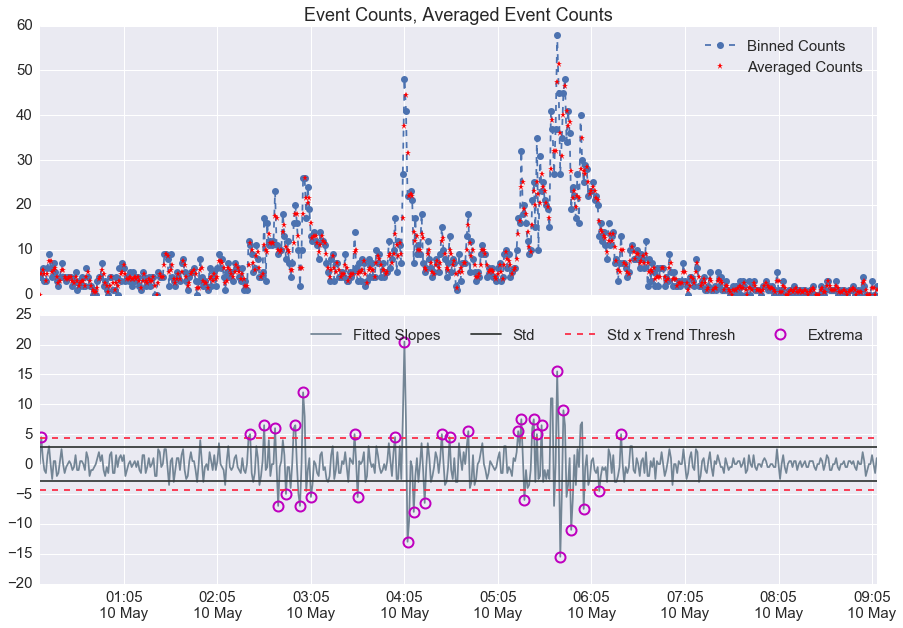

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import collections
import sys
import pickle
import logging
import numpy as np
import scipy.stats.distributions as dists
from sklearn.linear_model import LinearRegression
from dateutil import parser
import seaborn as sns
from IPython.display import HTML, clear_output, display
import pandas as pd
import ipywidgets as widgets
import math
import peakutils

class LinearRegressionModel(object):
    def __init__(self, config):
        self.counts = [] #make this numpy array 
        self.averaged_counts = [] #make this numpy array
        self.min_points = int(config['min_points'])
        try:
            self.averaging_window_size = int(config["averaging_window_size"]) 
        except KeyError:
            self.averaging_window_size = 1
        try:
            self.norm_by_mean = bool(config['norm_by_mean'])
        except KeyError:
            self.norm_by_mean = False
        try:
            self.regression_window_size = int(config['regression_window_size']) 
        except KeyError:
            self.regression_window_size = None
        self.regression = LinearRegression()

    def update(self, **kwargs):
        count = kwargs["count"]
        self.counts.append( count )
        
        size = self.averaging_window_size
        if len(self.counts) >= size:
            self.averaged_counts.append( sum(self.counts[-size:])/float(size) ) 
        else:
            self.averaged_counts.append(0) #Wtf is this?

    def get_result(self):
        """ Run a linear fit on the averaged count,
        which will be the raw counts if not otherwise specified. """
        if len(self.averaged_counts) < self.min_points:
            return 0 #Wtf is this?
        if self.regression_window_size is not None:
            y = np.array(self.averaged_counts[-self.regression_window_size:])  
        else:
            y = np.array(self.averaged_counts)  
        if self.norm_by_mean: 
            y = y/np.mean(y)
        x = range(len(y))
        X = [[i] for i in x]
        slope = self.regression.fit(X,y).coef_[0]
        return slope

sns.set_context('notebook', font_scale = 1.5)
sns.set_style('darkgrid')

abvs = "DHTS"
abvmap = {"D": (60*60*24, "Days"), "H": (60*60,23.0, "Hours"), 
           "T": (60.0, 59.0, "Minutes"), "S": (1.0, 59.0, "Seconds")}

def get_limit(ts, info):
    r = math.floor(ts / info[0])
    if r > info[1]:
        return info[1]
    return r
    
class EventCounts(object):
    def __init__(self, data):
        self.dates = pd.DatetimeIndex([r[-1]['created_at'] for r in data if 'created_at' in r[-1]])
        self.drange = self.dates.max() - self.dates.min()
        self.options = {}
        for i, c in enumerate(self.drange.components):
            if c > 0:
                self.options = abvs[i:]
                self.ranges = {abvmap[abv][-1]: [abv, 1.0, get_limit(self.drange.total_seconds(), abvmap[abv])] 
                               for abv in self.options}
                break
            else:
                continue   
                
class EventStatistics(object):
    def __init__(self, ecs):
        self.ecs = ecs
        self.resolution = widgets.Dropdown()
        self.resolution.options = self.ecs.ranges
        self.resolution.description = "Binning resolution"
        self.resolution.value = self.ecs.ranges['Minutes']
        self.resolution.observe(self.update_binrange, 'value')
        self.binrange = widgets.FloatSlider(min=self.resolution.value[1], max=self.resolution.value[2], step=1.0, 
                                            continuous_update=False, description = "Bin size              ")
        self.binrange.observe(self.update_windowsizes)
        self.aws = widgets.FloatSlider(min=2, max=self.resolution.value[2], step=1.0, 
                                            continuous_update=False, description = "Averaging Window Size ")
        self.rws = widgets.FloatSlider(min=2, max=self.resolution.value[2], step=1.0, 
                                            continuous_update=False, description = "Regression Window Size")
        self.thresh = widgets.FloatText(description="Threshold", value=1.5)
        self.count_container = widgets.VBox(children=[self.resolution, self.thresh])
        self.count_container.align = 'baseline'
        self.reg_container = widgets.VBox(children=[self.binrange, self.aws, self.rws])
        self.reg_container.align='end'

        
    def update_binrange(self, *args):
        self.binrange.min = self.resolution.value[1]
        self.binrange.max = self.resolution.value[2]
    
    def update_windowsizes(self, *args):
        self.aws.max = self.binrange.max
        self.rws.max = self.binrange.max
    
    def plot_counts(self, res, val, aws, rws, thr):
        f, axs = plt.subplots(2,1, figsize=(15, 10), sharex=True)
        self.ax1, self.ax2 = axs
        
        self.events = self.ecs.dates.to_series().resample(str(int(val)) + res[0]).count()      
        self.ax1.plot(self.events, '--o')

        lrmod = LinearRegressionModel({"min_points": rws, "norm_by_mean": None, "averaging_window_size": aws,
                                      "regression_window_size": rws})
        slopes = []
        for c in self.events:
            lrmod.update(count=c)
            slopes.append(lrmod.get_result())
        std = np.std(np.array(slopes))
        self.slopes = pd.Series(data=np.array(slopes), index=self.events.index)
        self.pstd = pd.Series(data=np.array([std]*len(slopes)), index=self.events.index)
        self.pthr = pd.Series(data=np.array([std * thr]*len(slopes)), index=self.events.index)
        self.nstd = pd.Series(data=np.array([-std]*len(slopes)), index=self.events.index)
        self.nthr = pd.Series(data=np.array([-std * thr]*len(slopes)), index=self.events.index)
        
        indexes = peakutils.indexes(np.array(stats.slopes.abs()), thres=0.1, min_dist=0)
        self.peaks = stats.slopes[indexes][stats.slopes[indexes].abs() > self.pthr[0]]
        
        self.ax1.hold = True
        self.ax1.plot(pd.Series(data=np.array(lrmod.averaged_counts), index=self.events.index), "*r")
        self.ax1.hold = False
        self.ax2.hold = True
        self.ax2.plot(self.slopes, '-', color=sns.xkcd_rgb['steel'])
        self.ax2.plot(self.pstd, '-', color=sns.xkcd_rgb['charcoal'])
        self.ax2.plot(self.pthr, '--', color=sns.xkcd_rgb['strawberry'])
        self.ax2.plot(self.peaks, 'o', markersize=10.0, markeredgecolor='m', markeredgewidth='2.0', 
                      markerfacecolor='None')
        self.ax2.plot(self.nstd, '-', color=sns.xkcd_rgb['charcoal'])      
        self.ax2.plot(self.nthr, '--', color=sns.xkcd_rgb['strawberry'])

        self.ax2.hold = False
        self.ax1.legend(["Binned Counts", "Averaged Counts"], )
        self.ax1.set_title("Event Counts, Averaged Event Counts")
        self.ax2.legend(["Fitted Slopes", "Std", "Std x Trend Thresh", "Extrema"], ncol=4)
        tks = self.ax2.xaxis.get_ticklocs()
        tls = [l.get_text() for l in self.ax2.xaxis.get_ticklabels()]
        self.ax2.xaxis.set_ticks(tks)
        self.ax2.xaxis.set_ticklabels(tls, rotation=0.0)
        self.ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%m\n%d %b'))
        f.subplots_adjust(hspace=0.075)
        
stats = EventStatistics(EventCounts(data))
i = widgets.interactive(stats.plot_counts, res=stats.resolution, val=stats.binrange, 
                        aws=stats.aws, rws=stats.rws, thr = stats.thresh)
Box = widgets.FlexBox([stats.count_container, stats.reg_container])
Box.orientation = "horizontal"
Box.pack = "stretch"
Box.flex=1
Box.on_displayed(lambda _: stats.plot_counts(res=stats.resolution.value[0], val=stats.binrange.value, 
                                              aws=stats.aws.value, rws=stats.rws.value, thr=stats.thresh.value))
Box.background_color = "#ced1d5"
Box.width = 900
display(HTML("""<h3>Select Binning Resolution, size and regression windowing values</h3>"""))
display(HTML("""<h3>Set the Event Threshold to a multiple of the standard deviation of the slope values</h3>"""))
display(Box)

In [9]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output

class DataPreserve(object):
    def __init__(self, data):
        self.data = data
        
try:
    _data = original.data
except NameError, ne:
    original = DataPreserve(data)

_data = original.data
dates, texts = zip(*[(r['created_at'], r['text']) for oids, r in _data if "created_at" in r])
ind= pd.DatetimeIndex(dates)
dd = pd.DataFrame(np.array(texts), index=ind, columns=["texts"])

head = widgets.Text(description="Start time")
tail = widgets.Text(description="End time")
slice_button = widgets.Button(description="Slice Data")
reset_button = widgets.Button(description="Reset Data")
hbox = widgets.HBox(children=[head, tail, slice_button, reset_button])
start = ind[0].ctime()
end = ind[-1].ctime()
display(HTML("""<h2>Original Data Time Range: %s -- %s</h2>"""%(start, end)))
display(hbox)
global new_output

def slice_data(b):
    global data
    clear_output()
    t = dd[head.value: tail.value]
    id1, id2 = (dd.index.get_loc(t.index[0]), dd.index.get_loc(t.index[-1]))
    data = _data[get_first(id1):get_first(id2)]
    display(HTML("""<h2>Original Data Time Range: %s -- %s</h2>"""%(start, end)))
    new_output = HTML("""<h2>New Data Time Range: %s -- %s</h2>"""%(t.index[0].ctime(), t.index[-1].ctime()))
    display(new_output)
    return data
    
def get_first(_idx):
    if isinstance(_idx, np.ndarray):
        for i, v in enumerate(_idx.tolist()):
            if v:
                _idx = i
                break
    return _idx

def reset_data(b):
    global data
    clear_output()
    data = original.data
    display(HTML("""<h2>Original Data Time Range: %s -- %s</h2>"""%(start, end)))
    new_output = HTML("""<h2>Data Time Range Reverted to Original</h2>""")
    display(new_output)
    return data
            
slice_button.on_displayed(lambda _: _)
reset_button.on_displayed(lambda _: _)
slice_button.on_click(slice_data)
reset_button.on_click(reset_data)

In [13]:
import re
import nltk
from collections import defaultdict
from string import digits
from gensim import corpora, models
import pyLDAvis.gensim

def is_tweet(msg):
    return "text" in msg

def tokenize_tweets( data ):
    """ Returns a list of token lists from tweet texts """
    ids, tweets = zip(*[(oid, rec) for (oid, rec) in data if is_tweet(rec)])

    def tokenize(text):
        tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        return tokenizer.tokenize(remove_urls(text).lower())

    def remove_urls(text):
        text = re.sub(r"(?:\@|http?\://)\S+", "", text)
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)
        return text.strip()

    def count_tokens(texts):
        freq = defaultdict(int)
        for text in texts:
            for token in text:
                freq[token] += 1
        return freq

    def token_condition(token, freq, stoplist):
        return (token not in stoplist 
                and len(token.strip(digits)) == len(token)
                and len(token) > 2
                and freq[token] > 1)

    def best_tokens(tokens, freq, stoplist):
        return [ [ t for t in tokens if token_condition(t, freq, stoplist) ] for tokens in texts ]

    def all_stopwords():
        return set(nltk.corpus.stopwords.words("english")
                        + nltk.corpus.stopwords.words("french")
                        + nltk.corpus.stopwords.words("german"))


    texts = [tokenize(x['text']) for x in tweets]
    token_frequency = count_tokens(texts)
    stoplist = all_stopwords()

    return best_tokens(texts, token_frequency, stoplist)
    
def ldaViz(tokens, num_topics=10, passes=10, alpha=0.001):
    dictionary = corpora.Dictionary(tokens)
    dictionary.compactify()

    corpus = [dictionary.doc2bow(tokenlist) for tokenlist in tokens]

    lda = models.LdaModel(corpus, id2word=dictionary,
                        num_topics = 10,
                        passes = 20,
                        alpha = 0.001)
    
    return pyLDAvis.gensim.prepare(lda, corpus, dictionary)
    
            
tokens = tokenize_tweets( data )
pyLDAvis.display(ldaViz( tokens, num_topics=50, passes=20, alpha=0.001 ))


In [17]:
import nltk
import urllib2
import json
from shapely.geometry import Point, shape
from collections import defaultdict
from string import digits
from gensim import corpora, models
import re
import pyLDAvis.gensim
from nltk.stem.porter import PorterStemmer


def tokenize_tweets( tweets, stops=[] ):
    """ Returns a list of token lists from tweet texts and maps tweets to location key"""
    def tokenize(text):
        tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        return tokenizer.tokenize(remove_urls(text).lower())

    def remove_urls(text):
        text = re.sub(r"(?:\@|http?\://)\S+", "", text)
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)
        return text.strip()

    def count_tokens(texts):
        freq = defaultdict(int)
        for text in texts:
            for token in text:
                freq[token] += 1
        return freq

    def token_condition(token, freq, stoplist):
        return (token not in stoplist 
                and len(token.strip(digits)) == len(token)
                and len(token) > 2
                and freq[token] > 1)

    def best_tokens(tokens, freq, stoplist):
        return [ [ t for t in tokens if token_condition(t, freq, stoplist) ] for tokens in texts ]

    def all_stopwords():
        return set(stops + nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("spanish"))

    
    p_stemmer = PorterStemmer()
    texts = [[p_stemmer.stem(i) for i in tokenize(x['text'])] for x in tweets]
    token_frequency = count_tokens(texts)
    stoplist = all_stopwords()

    return best_tokens(texts, token_frequency, stoplist), token_frequency

def create_geo_tokens( tweets, tokens ):
    geo_tokens = defaultdict(list)
    for i, g in enumerate(tweets):
        latlon = None
        if g['coordinates'] is not None:
            coords = g['coordinates']['coordinates']
            latlon = [coords[1], coords[0]]
            
        elif g['place'] is not None:
            coords = g['place']['bounding_box']['coordinates'][0]
            x, y = zip(*coords)
            avgy = sum(y)/float(len(y))
            avgx = sum(x)/float(len(x))
            latlon = [avgy, avgx]
           
        if latlon is not None:
            for token in tokens[i]:
                geo_tokens[token].append(latlon)
                
    return geo_tokens 
    

def run_lda(tokens):
    dictionary = corpora.Dictionary(tweet_tokens)
    dictionary.compactify()
    corpus = [dictionary.doc2bow(tokenlist) for tokenlist in tweet_tokens]
    model = models.LdaModel(corpus, id2word=dictionary,
                        num_topics = 10,
                        passes = 20,
                        alpha = 0.001)
    lda = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    
    return [[str(t.encode('utf-8')).strip().split('*') for t in topic[1].split('+')] for topic in model.print_topics()], lda

ignore_words = ['NBA', 'nba']
ids, rows = zip(*data)
tweet_tokens, token_frequency = tokenize_tweets( rows, stops=ignore_words)
geo_tokens = create_geo_tokens( rows, tweet_tokens )
topics, lda = run_lda(tweet_tokens)


import urllib2
import json
from shapely.geometry import Point, shape


def aggregate(url, prop, topics, geo_tokens):
    response = urllib2.urlopen(url)
    geoms = json.load(response)
    _terms = {}

    for feature in geoms['features']:
        name = feature['properties'][prop]
        feature['properties']['terms'] = {}
        for topic in topics:
            for term in topic:
                for ll in geo_tokens[term[1]]:
                    try:
                        point = Point(ll[1], ll[0])
                        poly = shape(feature['geometry'])
                        inside = point.within(poly)
                        if inside:
                            if name not in _terms:
                                _terms[name] = { 'total_count': 0 }

                            if term[1] not in _terms[name]:
                                _terms[name][term[1]] = 1
                            else:
                                _terms[name][term[1]] += 1
                                
                            _terms[name]['total_count'] += 1
                            break
                    except:
                        pass
    return _terms

# country_terms = aggregate(
#     'https://raw.githubusercontent.com/chelm/geodata/master/world-countries.geojson',
#     'name',
#     topics,
#     geo_tokens)

state_geojson = "https://raw.githubusercontent.com/datasets/geo-boundaries-us-110m/master/json/ne_110m_admin_1_states_provinces_shp.geojson"
state_terms = aggregate(
    state_geojson,
    'name',
    topics,
    geo_tokens)
  

                        
from IPython.display import HTML
from IPython.core.display import display_html, display_javascript, Javascript
import json, time
from string import Template

html = """<h2>Geospatial LDA from Tweets</h2>
<style> 
    div.output_area svg { max-width: none; } 
    div.output_area .rendered_html img { margin-top: 0; }
    .rendered_html :link { text-decoration: none; }
    text { font: 10px sans-serif;}
    .bubble {cursor: pointer}
    
.axis {
    stroke: #aaa;
    stroke-width: .5px;
    fill: none;
}
.boundary {
    fill: none;
    stroke-width: .5px;
    stroke: #ddd;
}

.borders {
  stroke-width: .5px;
  fill: none;
  stroke: #aaa;
  stroke-linejoin: round;
  stroke-linecap: round;
}

.bar {
    fill: #08c;
}

.dot {
    fill: #08c;
    fill-opacity: 0.5;
    cursor: pointer;
}
.dot:hover {
   fill-opacity: 0.75;
   stroke: #aaa;
}
.state, .q0   { fill:#aaa; }
.q0-9 { fill:rgb(247,251,255); }
.q1-9 { fill:rgb(222,235,247); }
.q2-9 { fill:rgb(198,219,239); }
.q3-9 { fill:rgb(158,202,225); }
.q4-9 { fill:rgb(107,174,214); }
.q5-9 { fill:rgb(66,146,198); }
.q6-9 { fill:rgb(33,113,181); }
.q7-9 { fill:rgb(8,81,156); }
.q8-9 { fill:rgb(8,48,107); }

.left{
   position: relative;
   float: left;
   left: 5.00%;
   width: 35.00%;
}
.right{
   position: relative;
   float: right;
   right: 5.00%;
   width: 51.00%;
}

.text{
    font: 14px sans-serif;
    fill: #555;
    stroke: #555;
    stroke-width: 0px;
}

.legend text {
    font: 8px sans-serif;
    fill: #fff;
    stroke: #fff;
    stroke-width: 0px;
    text-shadow: 0 0 5px #555
}

.tick text {
    fill: #555;
    stroke-width: 0px;
}

</style>
<link rel="stylesheet" href="http://cdn.leafletjs.com/leaflet/v0.7.7/leaflet.css" />
<div class="left">
    <div id="chart2"></div>
    <div id="bar2"></div>
</div>
<div class="right" id="map2"></div>
"""

d3js = Template("""

var topics = $topics;
var topic_dots = $topic_dots;
var state_terms = $state_terms;
var term_frequency = $term_frequency;

var terms = topics[0];
var totals = Object.keys(state_terms).map( function(s){ return state_terms[s]['total_count']; });
var term_max = d3.max(totals, function(d) { return d; });

var width = 500,
    height = 300;

var projection = d3.geo.albersUsa()
    .scale(532.6397607430363)
    .translate([width/2,height/2]) 

var path = d3.geo.path()
    .projection(projection);

var svg = d3.select("#map2").append("svg")
    .attr("width", width)
    .attr("height", height);

d3.json("https://raw.githubusercontent.com/jgoodall/us-maps/master/topojson/state.json", function(error, us) {
    if (error) throw error;
    
    var max = 0;
    var counts = {};
    topojson.feature(us, us.objects.state).features.forEach( function( state ) {
      var name = state.properties.NAME10;
      counts[name] = [];
      topics.forEach( function(terms) {
        var count = 0;
        terms.forEach(function(term){
          if (state_terms[name] && state_terms[name][term[1]]) {
            count += state_terms[name][term[1]];
          }
        });
        counts[name].push(count);
        max = Math.max(max, count);
      });
    });
    
    
    window.quantile = d3.scale.quantile()
        .domain([0, max+2])
        .range(d3.range(9).map(function(i) { return "q" + i + "-9"; }));
    
    var ext_color_domain = quantile.quantiles(); //.map(function(v){ return Math.round(v)}); //[0, 50, 150, 350, 750, 1500]
    //var legend_labels = ["< 50", "50+", "150+", "350+", "750+", "> 1500"] 
    //console.log(quantile)
  
    svg.selectAll("path")
      .data(topojson.feature(us, us.objects.state).features)
      .enter().append("path")
      .attr('class', function(d){
          return 'state ' + quantile(counts[d.properties.NAME10][0]);
        })
      .attr("d", path);
      
     svg.append("path")
      .datum(topojson.mesh(us, us.objects.state, function(a, b) { return a !== b; }))
      .attr("class", "borders")
      .attr("d", path);
      
    svg.append("path")
      .datum(topojson.mesh(us, us.objects.state, function( a, b ) { return a !== b && !(a.id / 1000 ^ b.id / 1000); }))
      .attr("class", "borders")
      .attr("d", path);
      

    var legend = svg.selectAll("g.legend")
      .data(ext_color_domain)
      .enter().append("g")
      .attr("transform", "translate(300,0)")
      .attr("class", "legend");

    var ls_w = 15, ls_h = 15;

    legend.append("rect")
      .attr("y", 20)
      .attr("x", function(d, i){ return 100 - ((i*ls_h) - 2*ls_h);})
      .attr("width", ls_w)
      .attr("height", ls_h)
      .attr("class", function(d){ return quantile(d);})
      .style("opacity", 0.8);

    legend.append("text")
      .attr("y", 30)
      .attr("x", function(d, i){ return 100 - ((i*ls_h) - (2*ls_h)-3);})
      .text(function(d, i){ return Math.round(d); });



    var data = topic_dots;

    var margin = {top: 20, right: 20, bottom: 20, left: 20}, 
        width = 350 - margin.left - margin.right,
        height = 250 - margin.top - margin.bottom;

    var x = d3.scale.linear()
        .domain([-3, 3])
        .range([ 0, width ]);

    var y = d3.scale.linear()
         .domain([-3, 3])
         .range([ height, 0 ]);

    var chart = d3.select('#chart2')
      .append('svg:svg')
      .attr('width', width + margin.right + margin.left)
      .attr('height', height + margin.top + margin.bottom)
      .attr('class', 'chart')

    var main = chart.append('g')
      .attr('transform', 'translate(' + margin.left + ',' + margin.top + ')')
      .attr('width', width)
      .attr('height', height)
      .attr('class', 'main')   

    // draw the x axis
    var xAxis = d3.svg.axis()
    .scale(x)
    .ticks(0)
    .outerTickSize(0)
    .orient('bottom');


    main.append('g')
      .attr('transform', 'translate(0,' + height/2 + ')')
      .attr('class', 'main axis date')
      .call(xAxis);

    // draw the y axis
    var yAxis = d3.svg.axis()
      .scale(y)
      .ticks(0)
      .outerTickSize(0)
      .orient('left');

    main.append('g')
      .attr('transform', 'translate('+ width/2 +',0)')
      .attr('class', 'main axis')
      .call(yAxis);

    var g = main.append("svg:g"); 

    var dots = g.selectAll("scatter-dots")
        .data(data)
        .enter();
        //.attr('class', 'dot')
        
    dots.append("circle")
        .attr('class', 'dot')
        .attr("cx", function (d,i) { return x(d[2]*10); } )
        .attr("cy", function (d) { return y(d[1]*10); } )
        .attr("r", function (d) { return d[0]*2; } )
        .on('mouseover', function(d,i){ updateViz(i); });
        
    dots.append("text")
      .attr("dx", function (d,i) { return x(d[2]*10)-3; })
      .attr("dy", function (d,i) { return y(d[1]*10)+3; })
      .text(function(d, i){ return i+1; });

    var margin = {top: 20, right: 20, bottom: 50, left: 40},
        width = 360 - margin.left - margin.right,
        height = 200 - margin.top - margin.bottom;

    var x = d3.scale.ordinal()
        .rangeRoundBands([0, width], .1);

    var y = d3.scale.linear()
        .range([height, 0]);

    var xAxis = d3.svg.axis()
        .scale(x)
        .orient("bottom");

    var yAxis = d3.svg.axis()
        .scale(y)
        .orient("left")
        .ticks(10, "");

    var barsvg = d3.select("#bar2").append("svg")
        .attr("class", ".barchart")
        .attr("width", width + margin.left + margin.right)
        .attr("height", height + margin.top + margin.bottom)
      .append("g")
        .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

      x.domain(terms.map(function(d) { return d[1]; }));
      y.domain([0, term_max]);
      

      barsvg.append("g")
          .attr("class", "x axis")
          .attr("transform", "translate(0," + height + ")")
          .call(xAxis)
          .selectAll("text")  
            .style("text-anchor", "end")
            .attr("dx", "-.8em")
            .attr("dy", ".15em")
            .attr("transform", "rotate(-65)" );
       

      barsvg.append("g")
          .attr("class", "y axis")
          .call(yAxis)
          
      var freq = terms.map(function(term){
        var count = 0;
        Object.keys(state_terms).forEach( function(s){ 
          count += state_terms[s][term[1]] || 0; 
        });
        return [term[1], count];
      });

      barsvg.selectAll(".bar")
          .data(freq)
        .enter().append("rect")
          .attr("class", "bar")
          .attr("x", function(d) { return x(d[0]); })
          .attr("width", x.rangeBand())
          .attr("y", function(d) {return y(d[1]); })
          .attr("height", function(d) { return height - y(d[1]); });


function updateViz(topic) {
    var terms = topics[topic];
    
    d3.selectAll('.state')
        .attr('class', function(d){
          var count = 0;
          terms.forEach(function(term){
            if (state_terms[d.properties.NAME10] && state_terms[d.properties.NAME10][term[1]]) {
              count += state_terms[d.properties.NAME10][term[1]]
            }
          })
          return 'state ' + quantile(count);
        });
        
    var freq = terms.map(function(term){
      var count = 0;
      Object.keys(state_terms).forEach( function(s){ 
          count += state_terms[s][term[1]] || 0; 
      });
      return [term[1], count];
    });
    
    x.domain(freq.map(function(d) { return d[0]; }));
  
    d3.select("g.y")
        .call(yAxis);

    d3.select("g.x")
      .call(xAxis)
      .selectAll("text") 
        .style("text-anchor", "end")
        .attr("dx", "-.8em")
        .attr("dy", ".15em")
        .attr("transform", "rotate(-65)" );

       
   
    d3.selectAll('.bar')
      .attr("x", function(d,i) { return x(freq[i][0]); })
      .attr("y", function(d,i) { return y(freq[i][1]); })
      .attr("height", function(d,i) { return height - y(freq[i][1]); });
}   

});
""")

js_libs = ['https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.6/d3.min.js', 'http://d3js.org/topojson.v1.min.js']
display_javascript( Javascript(data='', lib=js_libs))

time.sleep(1)

def renderd3(html, js, libs=[]):   
    display_html(HTML(data=html))
    display_javascript( Javascript(data=js, lib=libs))

topic_dots = [[x[0], x[-2], x[-1]] for x in lda[0].values]

d3js = d3js.substitute({
        "topics": topics, 
        "topic_dots": topic_dots, 
        "state_terms": json.dumps(state_terms),
        "term_frequency": json.dumps(token_frequency)
    })
                        
renderd3(html, d3js)

Geospatial LDA from Tweets